In [1]:
import os, tf2onnx, keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import LSTM, Dense

from utils.crane_dataset import CraneDataset
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler

In [2]:
train_data_file_path_list = ['safe-boom-40-swing-180-load-40-.csv', 'safe-boom-50-swing-180-load-50-.csv',
                             'safe-boom-60-swing-180-load-60-.csv', 'safe-boom-70-swing-180-load-100-.csv',
                             'unsafe-swing-0-load-70-.csv', 'unsafe-swing-0-load-90-.csv',
                             'unsafe-swing-45-load-50-.csv', 'unsafe-swing-45-load-70-.csv',
                             'unsafe-swing-90-load-70-.csv', 'unsafe-swing-90-load-90-.csv',
                             'unsafe-swing-135-load-50-.csv', 'unsafe-swing-135-load-70-.csv']

for i, file_path in enumerate(train_data_file_path_list):
    train_data_file_path_list[i] = os.path.join('data', file_path)

In [3]:
val_data_file_path_list = ['safe-boom-80-swing-180-load-120-.csv', 'unsafe-swing-180-load-70-.csv', 'unsafe-swing-180-load-90-.csv']

for i, file_path in enumerate(val_data_file_path_list):
    val_data_file_path_list[i] = os.path.join('data', file_path)

In [4]:
train_dataset_inst = CraneDataset(train_data_file_path_list)
val_dataset_inst = CraneDataset(val_data_file_path_list)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
raw_train_dataset = train_dataset_inst.get_dataset()
raw_val_dataset = val_dataset_inst.get_dataset()

In [6]:
raw_train_data = raw_train_dataset[train_dataset_inst.get_data_target_names()]
raw_train_data = raw_train_data.to_numpy()
raw_train_data = raw_train_data.T.flatten()
raw_train_data = raw_train_data[::10]

In [7]:
raw_val_data = raw_val_dataset[val_dataset_inst.get_data_target_names()]
raw_val_data = raw_val_data.to_numpy()
raw_val_data = raw_val_data.T.flatten()
raw_val_data = raw_val_data[::10]

In [8]:
scaler = RobustScaler().fit(raw_train_data.reshape(-1, 1))

<AxesSubplot:>

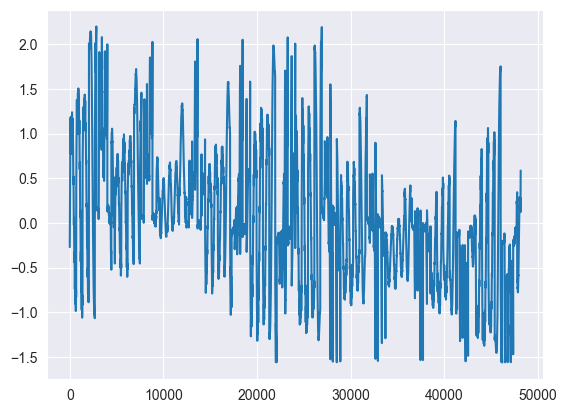

In [9]:
scaled_raw_train_data = scaler.transform(raw_train_data.reshape(-1, 1))
scaled_raw_train_data = scaled_raw_train_data.squeeze()
sns.lineplot(scaled_raw_train_data)

<AxesSubplot:ylabel='Density'>

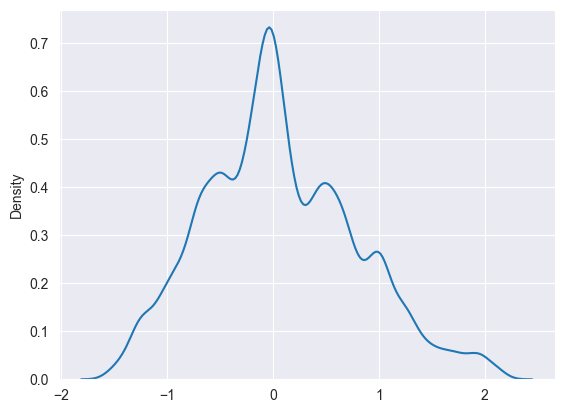

In [10]:
sns.kdeplot(scaled_raw_train_data)

<AxesSubplot:>

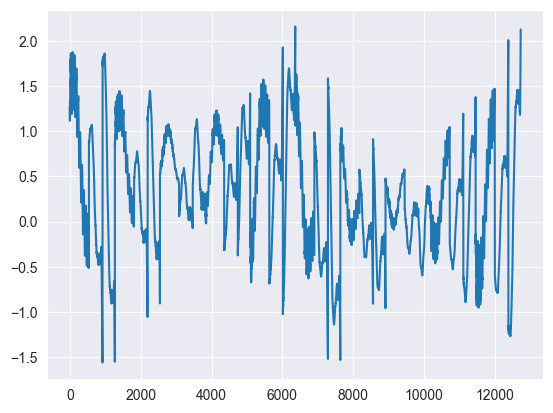

In [11]:
scaled_raw_val_data = scaler.transform(raw_val_data.reshape(-1, 1))
scaled_raw_val_data = scaled_raw_val_data.squeeze()
sns.lineplot(scaled_raw_val_data)

<AxesSubplot:ylabel='Density'>

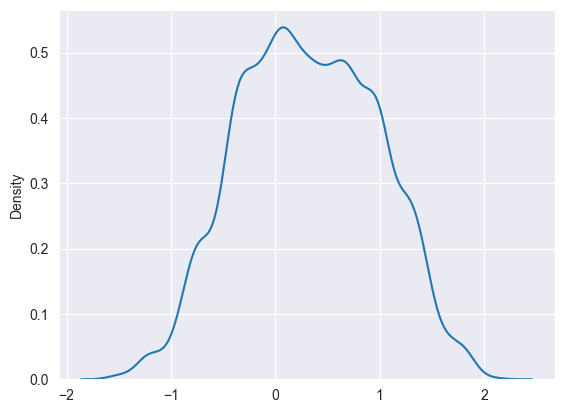

In [12]:
sns.kdeplot(scaled_raw_val_data)

In [13]:
# 데이터를 LSTM 입력 형태로 변환합니다.
def create_dataset(data, seq_len=1, pred_distance=1):
    feature, target = [], []
    
    for i in range(data.shape[0] - seq_len - pred_distance - 1):
        if i >= seq_len:
            feature.append(data[i-seq_len:i])
            target.append(data[i + pred_distance])
    
    return np.array(feature), np.array(target)

seq_len = 10
pred_distance = 30

scaled_x_train, scaled_y_train = create_dataset(data=scaled_raw_train_data, seq_len=seq_len, pred_distance=pred_distance)
scaled_x_val, scaled_y_val = create_dataset(data=scaled_raw_val_data, seq_len=seq_len, pred_distance=pred_distance)

# LSTM 입력에 맞게 데이터 형태를 조정합니다.
scaled_x_train = np.reshape(scaled_x_train, (scaled_x_train.shape[0], scaled_x_train.shape[1], 1))
scaled_x_val = np.reshape(scaled_x_val, (scaled_x_val.shape[0], scaled_x_val.shape[1], 1))

print(scaled_x_train.shape, scaled_y_train.shape, scaled_x_val.shape, scaled_y_val.shape)

(48117, 10, 1) (48117,) (12692, 10, 1) (12692,)


In [14]:
model_chk_point = ModelCheckpoint(filepath='model.h5', monitor="val_loss", verbose=1, save_best_only=True,
                                  save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)

In [15]:
optimizer = Adam(learning_rate=0.001)
hidden_size = 2048
n_of_feature = 1

early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
csv_logger = CSVLogger('log.csv', append=True, separator=',')

model = None
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(units=hidden_size, return_sequences=False, input_shape=(seq_len, n_of_feature), dropout=0.2))
    #model.add(Dense(units=1024, input_dim=hidden_size, activation='linear'))
    model.add(Dense(units=1, input_dim=hidden_size, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

In [16]:
history = model.fit(x=scaled_x_train, y=scaled_y_train, validation_data=(scaled_x_val, scaled_y_val), epochs=1000, batch_size=400, verbose=2, 
                    callbacks=[early_stop, csv_logger, model_chk_point])

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.10015, saving model to model.h5
121/121 - 5s - loss: 0.0818 - mean_absolute_error: 0.1638 - val_loss: 0.1002 - val_mean_absolute_error: 0.1739 - 5s/epoch - 41ms/step
Epoch 2/1000

Epoch 2: val_loss did not improve from 0.10015
121/121 - 2s - loss: 0.0695 - mean_absolute_error: 0.1469 - val_loss: 0.1067 - val_mean_absolute_error: 0.1810 - 2s/epoch - 14ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.10015 to 0.09627, saving model to model.h5
121/121 - 2s - loss: 0.0678 - mean_absolute_error: 0.1451 - val_loss: 0.0963 - val_mean_absolute_error: 0.1741 - 2s/epoch - 19ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 0.09627
121/121 - 2s - loss: 0.0681 - mean_absolute_error: 0.1462 - val_loss: 0.1068 - val_mean_absolute_error: 0.1852 - 2s/epoch - 14ms/step
Epoch 5/1000

Epoch 5: val_loss did not improve from 0.09627
121/121 - 2s - loss: 0.0680 - mean_absolute_error: 0.1458 - val_loss: 0.0984 - val_mean_absolute_error:

In [17]:
best_model = keras.models.load_model('model.h5')

In [18]:
y_train_pred = best_model.predict(scaled_x_train)
y_val_pred = best_model.predict(scaled_x_val)

397/397 [==============================] - 1s 2ms/step


In [19]:
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_pred = y_train_pred.squeeze()

y_val_pred = scaler.inverse_transform(y_val_pred.reshape(-1, 1))
y_val_pred = y_val_pred.squeeze()

#y_train_pred = np.exp(y_train_pred)
#y_val_pred = np.exp(y_val_pred)

#y_train_pred = (y_train_pred*train_std)+train_mean
#y_val_pred = (y_val_pred*train_std)+train_mean

y_train = scaler.inverse_transform(scaled_y_train.reshape(-1, 1))
y_train = y_train.squeeze()

y_val = scaler.inverse_transform(scaled_y_val.reshape(-1, 1))
y_val = y_val.squeeze()

#y_train = np.exp(scaled_y_train)
#y_val = np.exp(scaled_y_val)

#y_train = (scaled_y_train*train_std)+train_mean
#y_val = (scaled_y_val*train_std)+train_mean

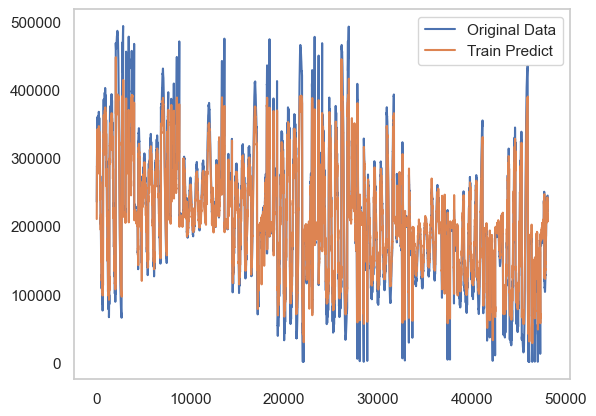

In [40]:
# 결과 시각화

# 원본 데이터, 학습 데이터에 대한 예측, 테스트 데이터에 대한 예측을 플롯팅합니다.
plt.plot(y_train, label='Original Data')
#train_predict_plot = np.zeros(shape=[])
#train_predict_plot[seq_len:len(train_predict) + seq_len + 10] = train_predict.reshape(-1)
plt.plot(y_train_pred, label='Train Predict')

#test_predict_plot = np.empty_like(data)
#test_predict_plot[:] = np.nan
#test_predict_plot[len(train_predict) + (seq_len * 2) + 1:len(data) - 1] = test_predict.reshape(-1)
#plt.plot(test_predict_plot, label='Test Predict')
plt.grid()
plt.legend()
plt.show()

In [21]:
print(r2_score(y_train, y_train_pred))
print(mean_absolute_error(y_train, y_train_pred))

0.8851707512679159
19691.666944320357


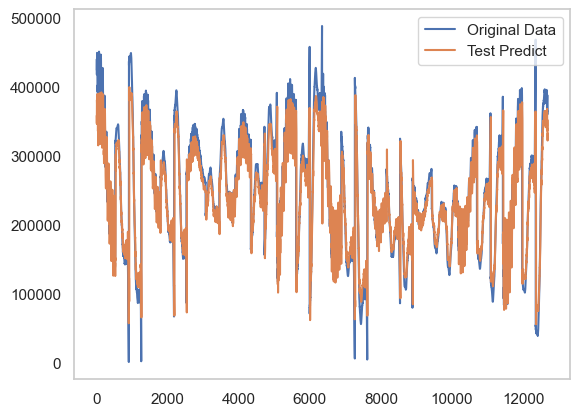

In [39]:
plt.plot(y_val, label='Original Data')
plt.plot(y_val_pred,  label='Test Predict')
plt.grid()
plt.legend()
plt.show()

In [23]:
print(r2_score(y_val, y_val_pred))
print(mean_absolute_error(y_val, y_val_pred))

0.8092005962070472
22063.59738696324


<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

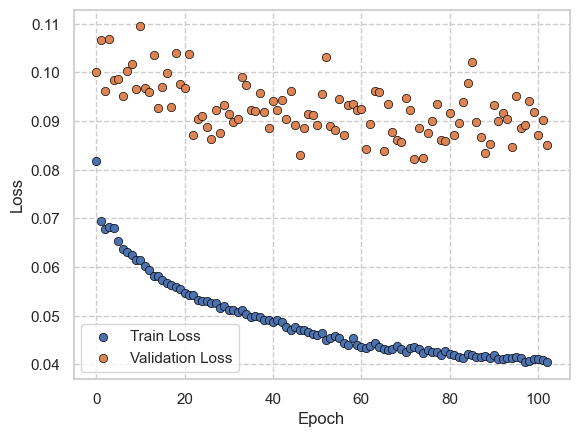

In [24]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Epoch')
plt.ylabel('Loss')

epoch_arr = np.arange(0, len(history.history['loss']), 1)
sns.scatterplot(x=epoch_arr, y=history.history['loss'], edgecolor='black', label='Train Loss')
sns.scatterplot(x=epoch_arr, y=history.history['val_loss'], edgecolor='black', label='Validation Loss')

<AxesSubplot:xlabel='Epoch', ylabel='Mean Error(N)'>

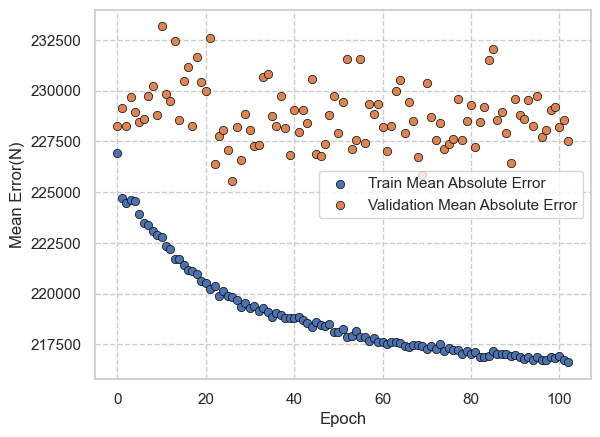

In [25]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Epoch')
plt.ylabel('Mean Error(N)')

train_abs_error = np.array(history.history['mean_absolute_error'])
train_abs_error = scaler.inverse_transform(train_abs_error.reshape(-1, 1))
train_abs_error = train_abs_error.squeeze()

val_abs_error = np.array(history.history['val_mean_absolute_error'])
val_abs_error = scaler.inverse_transform(val_abs_error.reshape(-1, 1))
val_abs_error = val_abs_error.squeeze()

sns.scatterplot(x=epoch_arr, y=train_abs_error, edgecolor='black', label='Train Mean Absolute Error')
sns.scatterplot(x=epoch_arr, y=val_abs_error, edgecolor='black', label='Validation Mean Absolute Error')

In [33]:
onnx_model, _ = tf2onnx.convert.from_keras(best_model)

In [34]:
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())